# 大作业要求

1.大作业以2-3人为一组完成，提交材料包括PPT（最后一次课将会展示课程成果）+ 最终的大作业报告（需组内各成员单独提交，内容为本人在课程大作业中的贡献以及对大作业问题的思考) + 提交包含分工情况及组内各成员工作量占比的表格。分工表格需组内所有成员签字确认；

2.禁止抄袭，发现雷同，所有雷同提交分数除以2；

3.写清楚大作业中的贡献和创新点，若使用开源代码和论文中的方法，在报告中必须注明（不可作为本人创新点），发现不标注引用，分数除以2。

最后一次课展示说明：
1.样例
PPT例子：https://www.sohu.com/a/166633625_642762
2.展示时间限制：
展示时间为2022.7.14（周四），展示时间为7分钟讲+3分钟同学助教老师自由提问

大作业报告：强调个人对问题的理解，以及贡献，建议增加在提问反馈之后的改进结果。

最终评分为:30%展示评分+70%大作业报告

# 问题描述(Out-of-Distribution)

深度神经网络通常采用独立同分布(Independent-Identically)的假设进行训练，即假设测试数据分布与训练数据分布相似。然而，当用于实际任务时，这一假设并不成立，导致其性能显著下降。虽然这种性能下降对于产品推荐等宽容性大的应用是可以接受的，但在医学等宽容性小的领域使用此类系统是危险的，因为它们可能导致严重事故。理想的人工智能系统应尽可能在分布外（Out-of-Distribution）的情况下有较强的分部外泛化能力。而提高分布外泛化的关键点，就是如何让模型学习到数据中的causal feature。  
一个简单的例子：以猫狗二分类为例，如果训练集中所有狗都在草地上，所有的猫都在沙发上，而测试集中所有的狗在沙发上，所有的猫在草地上，那么模型在没有测试集信息的情况下，很有可能根据训练集的信息把草地和狗联系在了一起，沙发和猫联系在了一起，当模型在测试集上测试时将会把在沙发上的狗误认为是猫。

# 数据集(Colored MNIST)

在第三次作业中已初步介绍过CMNIST，在该数据集中，训练集和测试集之间存在Out-of-Distribution情况，color feature和数字产生了spurious correlation，即虚假的因果关系。从直观上来说，数字的形状为causal feature，数字的颜色为non-causal feature。该次大作业旨在探索如何让模型学习到causal feature来提高泛化能力。

In [ ]:
import os

import numpy as np
from PIL import Image

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import grad
from torchvision import transforms
from torchvision import datasets
import torchvision.datasets.utils as dataset_utils

In [6]:
import os

import numpy as np
from PIL import Image

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import grad
from torchvision import transforms
from torchvision import datasets
import torchvision.datasets.utils as dataset_utils

def color_grayscale_arr(arr, red=True):
    """Converts grayscale image to either red or green"""
    assert arr.ndim == 2
    dtype = arr.dtype
    h, w = arr.shape
    arr = np.reshape(arr, [h, w, 1])
    if red:
        arr = np.concatenate([arr,
                              np.zeros((h, w, 2), dtype=dtype)], axis=2)
    else:
        arr = np.concatenate([np.zeros((h, w, 1), dtype=dtype),
                              arr,
                              np.zeros((h, w, 1), dtype=dtype)], axis=2)
    return arr


class ColoredMNIST(datasets.VisionDataset):
    """
  Colored MNIST dataset for testing IRM. Prepared using procedure from https://arxiv.org/pdf/1907.02893.pdf

  Args:
    root (string): Root directory of dataset where ``ColoredMNIST/*.pt`` will exist.
    env (string): Which environment to load. Must be 1 of 'train1', 'train2', 'test', or 'all_train'.
    transform (callable, optional): A function/transform that  takes in an PIL image
      and returns a transformed version. E.g, ``transforms.RandomCrop``
    target_transform (callable, optional): A function/transform that takes in the
      target and transforms it.
  """

    def __init__(self, root='./data', env='train1', transform=None, target_transform=None):
        super(ColoredMNIST, self).__init__(root, transform=transform,
                                           target_transform=target_transform)

        self.prepare_colored_mnist()
        if env in ['train1', 'train2', 'test']:
            self.data_label_tuples = torch.load(os.path.join(self.root, 'ColoredMNIST', env) + '.pt')
        elif env == 'all_train':
            self.data_label_tuples = torch.load(os.path.join(self.root, 'ColoredMNIST', 'train1.pt')) + \
                                     torch.load(os.path.join(self.root, 'ColoredMNIST', 'train2.pt'))
        else:
            raise RuntimeError(f'{env} env unknown. Valid envs are train1, train2, test, and all_train')

    def __getitem__(self, index):
        """
    Args:
        index (int): Index

    Returns:
        tuple: (image, target) where target is index of the target class.
    """
        img, target = self.data_label_tuples[index]

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        return len(self.data_label_tuples)

    def prepare_colored_mnist(self):
        colored_mnist_dir = os.path.join(self.root, 'ColoredMNIST')
        if os.path.exists(os.path.join(colored_mnist_dir, 'train1.pt')) \
                and os.path.exists(os.path.join(colored_mnist_dir, 'train2.pt')) \
                and os.path.exists(os.path.join(colored_mnist_dir, 'test.pt')):
            print('Colored MNIST dataset already exists')
            return

        print('Preparing Colored MNIST')
        train_mnist = datasets.mnist.MNIST(self.root, train=True, download=True)

        train1_set = []
        train2_set = []
        test_set = []
        for idx, (im, label) in enumerate(train_mnist):
            if idx % 10000 == 0:
                print(f'Converting image {idx}/{len(train_mnist)}')
            im_array = np.array(im)

            # Assign a binary label y to the image based on the digit
            binary_label = 0 if label < 5 else 1

            # Flip label with 25% probability
            if np.random.uniform() < 0.25:
                binary_label = binary_label ^ 1

            # Color the image either red or green according to its possibly flipped label
            color_red = binary_label == 0

            # Flip the color with a probability e that depends on the environment
            if idx < 20000:
                # 20% in the first training environment
                if np.random.uniform() < 0.2:
                    color_red = not color_red
            elif idx < 40000:
                # 10% in the first training environment
                if np.random.uniform() < 0.1:
                    color_red = not color_red
            else:
                # 90% in the test environment
                if np.random.uniform() < 0.9:
                    color_red = not color_red

            colored_arr = color_grayscale_arr(im_array, red=color_red)

            if idx < 20000:
                train1_set.append((Image.fromarray(colored_arr), binary_label))
            elif idx < 40000:
                train2_set.append((Image.fromarray(colored_arr), binary_label))
            else:
                test_set.append((Image.fromarray(colored_arr), binary_label))

            # Debug
            # print('original label', type(label), label)
            # print('binary label', binary_label)
            # print('assigned color', 'red' if color_red else 'green')
            # plt.imshow(colored_arr)
            # plt.show()
            # break

        dataset_utils.makedir_exist_ok(colored_mnist_dir)
        torch.save(train1_set, os.path.join(colored_mnist_dir, 'train1.pt'))
        torch.save(train2_set, os.path.join(colored_mnist_dir, 'train2.pt'))
        torch.save(test_set, os.path.join(colored_mnist_dir, 'test.pt'))

# 初级部分：数据预处理

1.在Colored MNIST上训练和测试LeNet。  
2.在数据读取过程中增加数据预处理的方式（数据增广等），提高OOD泛化能力 【若选做高级部分可以跳过】

【OOD算法性能评价准则：在训练过程中只能接触训练集，不能在测试集上进行调参或者模型选择】

In [6]:
# Baseline for LeNet on ColoredMNIST

import time
from torch.utils import data
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset

import torch.nn as nn
import torch.nn.functional as F




class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)  # input
        self.pool1 = nn.MaxPool2d(2, 2)  # pooling_kernel.size: 2*2
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):  # 输入数据，Tensor
        # print(x.size())
        x = F.relu(self.conv1(x))  # input(3, 28, 28) output(16, 24, 24)
        # print(x.size())
        x = self.pool1(x)  # output(16, 12, 12)
        # print(x.size())
        x = F.relu(self.conv2(x))  # output(32, 8, 8)
        # print(x.size())
        x = self.pool2(x)  # output(32, 4, 4)
        # print(x.size())
        x = x.view(-1, 32 * 4 * 4)  # output(32*4*4)
        # print(x.size())
        x = F.relu(self.fc1(x))  # output(120)
        # print(x.size())
        x = F.relu(self.fc2(x))  # output(84)
        # print(x.size())
        x = self.fc3(x)  # output(10)
        # print(x.size())
        return x






# shape (H x W x C) in the range [0, 255] → shape (C x H x W) in the range [0.0, 1.0]
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32

class ColoredMNIST(Dataset):
    def __init__(self, file_name):
        self.data_label = torch.load(file_name)
        # self.data_label=transforms.ToTensor()(self.data_label)

    def __getitem__(self, index):
        img, target = self.data_label[index]
        img = transforms.ToTensor()(img)
        return img, target

    def __len__(self):
        return len(self.data_label)

from torch.utils import data

train_dataset = ColoredMNIST('./dataset/ColoredMNIST_augmented/train1_augmented.pt') # path of dataset for training
train_loader = data.DataLoader(dataset=train_dataset,
                               batch_size=batch_size,
                               shuffle=True)

test_dataset = ColoredMNIST('./dataset/ColoredMNIST/test.pt') # path of dataset for testing
test_loader = data.DataLoader(dataset=test_dataset,
                              batch_size=batch_size,
                              shuffle=False)



val_data_iter = iter(test_loader)
val_image, val_label = val_data_iter.next()




# def imshow(img):
#     img = img/2+0.5    # unnormalize，反标准化还原回去
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1,2,0))) # C,H,W ——>H,W,C
#     plt.show()

net = LeNet()  # 定义训练所用的网络模型
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
states=[]
for epoch in range(10):

    running_loss = 0.0
    time_start = time.perf_counter()

    # 遍历训练集，step从0开始计算
    for step, data in enumerate(train_loader, start=0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)  # forward propagation
        loss = loss_function(outputs, labels)  # calculate loss
        loss.backward()  # back propagation
        optimizer.step()  # iterate and renew the parameters

        # print statistics（time,loss,accuracy etc.）
        running_loss += loss.item()
        if step % 500 == 499:  # print every 500 mini-batches
            with torch.no_grad():  # with是一个上下文管理器
                # gradient won't be changed within the function
                outputs = net(val_image)  # [batch, 10]测试集传入网络
                predict_y = torch.max(outputs, dim=1)[1]  # 以output中值最大位置（在第一维度）对应的索引（标签）作为预测输出
                accuracy = torch.eq(predict_y, val_label).sum().item() / val_label.size(0)

                # print epoch，step，loss，accuracy
                print('[%d, %5d] train_loss: %.3f  test_accuracy: %.3f' %
                      (epoch + 1, step + 1, running_loss / 500, accuracy))
                states.append([(running_loss / 500), accuracy])
                # print operation time
                print('%f s' % (time.perf_counter() - time_start))
                running_loss = 0.0

print('Finished Training')

# save model
save_path = './Lenet.pth'
torch.save(net.state_dict(), save_path)






[1,   500] train_loss: 0.693  test_accuracy: 0.438
4.513600 s
[1,  1000] train_loss: 0.603  test_accuracy: 0.531
8.407582 s
[1,  1500] train_loss: 0.589  test_accuracy: 0.531
12.006986 s
[1,  2000] train_loss: 0.579  test_accuracy: 0.562
15.610580 s
[1,  2500] train_loss: 0.577  test_accuracy: 0.531
19.141533 s
[1,  3000] train_loss: 0.576  test_accuracy: 0.531
22.659523 s
[1,  3500] train_loss: 0.563  test_accuracy: 0.562
26.214210 s
[1,  4000] train_loss: 0.565  test_accuracy: 0.562
29.736411 s
[1,  4500] train_loss: 0.560  test_accuracy: 0.531
33.261899 s
[1,  5000] train_loss: 0.563  test_accuracy: 0.531
36.802777 s
[1,  5500] train_loss: 0.566  test_accuracy: 0.594
40.301231 s
[1,  6000] train_loss: 0.553  test_accuracy: 0.562
43.806921 s
[2,   500] train_loss: 0.547  test_accuracy: 0.531
3.418426 s
[2,  1000] train_loss: 0.546  test_accuracy: 0.531
6.878763 s
[2,  1500] train_loss: 0.547  test_accuracy: 0.594
10.353103 s
[2,  2000] train_loss: 0.537  test_accuracy: 0.531
13.79645

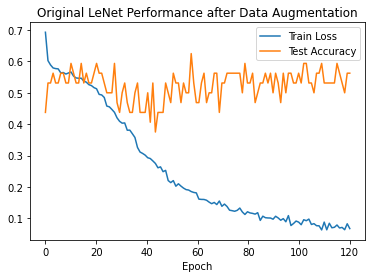

[[0.69298059 0.4375    ]
 [0.60250722 0.53125   ]
 [0.58878508 0.53125   ]
 [0.5792144  0.5625    ]
 [0.57711322 0.53125   ]
 [0.57625416 0.53125   ]
 [0.56340015 0.5625    ]
 [0.56456282 0.5625    ]
 [0.55980133 0.53125   ]
 [0.56308769 0.53125   ]
 [0.5663931  0.59375   ]
 [0.55312777 0.5625    ]
 [0.54737211 0.53125   ]
 [0.5463456  0.53125   ]
 [0.54658813 0.59375   ]
 [0.5374463  0.53125   ]
 [0.53383052 0.5625    ]
 [0.52596819 0.53125   ]
 [0.52292645 0.53125   ]
 [0.5164454  0.5625    ]
 [0.51277863 0.59375   ]
 [0.494962   0.5625    ]
 [0.49323424 0.5625    ]
 [0.48519441 0.53125   ]
 [0.45773331 0.5       ]
 [0.4552513  0.5       ]
 [0.44687508 0.5       ]
 [0.43766519 0.59375   ]
 [0.42019269 0.46875   ]
 [0.40913493 0.4375    ]
 [0.40324844 0.5       ]
 [0.403954   0.53125   ]
 [0.38074669 0.46875   ]
 [0.38103905 0.4375    ]
 [0.36952818 0.4375    ]
 [0.35756223 0.5       ]
 [0.32580443 0.53125   ]
 [0.31120614 0.4375    ]
 [0.30678092 0.4375    ]
 [0.30137984 0.4375    ]


In [8]:
import numpy as np
from matplotlib import pyplot as plt
steps = np.linspace(0, 120, 120)
states = np.array(states)

plt.figure()
# plt.plot(steps, states[:, 0], c='blue', label='Loss')
plt.plot(steps, states[:,0], label='Train Loss')
plt.plot(steps, states[:,1], label='Test Accuracy')
plt.xlabel('Epoch')
plt.title('Original LeNet Performance after Data Augmentation')
plt.legend()
plt.show()
print(states)

# 中级部分：算法复现

https://github.com/facebookresearch/DomainBed  
1.复现Invariant Risk Minimization (IRM)算法。  
2.从以下论文中选择一个OOD算法复现，思考什么样的算法可以在此数据集上取得较好效果。  
    - Domain-Adversarial Training of Neural Networks (DANN)    
    - Out-of-Distribution Generalization via Risk Extrapolation (VREx)  
    - Learning Explanations that are Hard to Vary (AndMask)  
    - Self-Challenging Improves Cross-Domain Generalization (RSC)   
3.IRM算法对penalty weight参数较为敏感，如何改进，提高IRM算法稳定性。

# 高级部分：探索OOD算法

证明、分析算法的因果推理能力和收敛性。